# Downstream analysis of clusters per cell/membrane

In [1]:
import matplotlib.pyplot as plt
from locpix.preprocessing import datastruc
from locpix.visualise import vis_img
from locpix.img_processing import render
import os
import numpy as np
import json
import seaborn as sns
import pandas as pd
import polars as pl
from sklearn.cluster import DBSCAN
from scipy.spatial import ConvexHull
from sklearn.neighbors import NearestNeighbors


## Define functions

In [11]:
def convex_hull(array):
    """Convex hull function

    Args:
        array (numpy array) : Input array

    Returns:
        perimieter (float) : Perimeter of the 2D convex hull
        area (float) : Area of the convex hull
        np.max(neigh_dist) : Maximum length of the convex hull"""

    hull = ConvexHull(array)
    vertices = hull.vertices
    neigh = NearestNeighbors(n_neighbors=len(vertices))
    neigh.fit(array[vertices])
    neigh_dist, _ = neigh.kneighbors(array[vertices], return_distance=True)
    perimeter = hull.area
    area = hull.volume
    length = np.max(neigh_dist)
    # print("length via convex hull", length)
    return perimeter, area, length

def cluster(df, eps, min_samples, print_results=True):
    arr = df[["x", "y"]].to_numpy()
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(arr)

    df = df.with_columns(
            pl.lit(clustering.labels_.astype("int32")).alias("clusterID")
    )
    
    # drop unclustered points
    df = df.filter(pl.col("clusterID") != -1)

    # Dropping all clusters with 2 or fewer locs - otherwise convex hull fails
    small_clusters = df.group_by("clusterID").len().filter(pl.col("len") < 3)
    df = df.filter(~pl.col("clusterID").is_in(small_clusters["clusterID"]))

    # remap the clusterIDs
    unique_clusters = list(df["clusterID"].unique())
    map = {value: i for i, value in enumerate(unique_clusters)}
    df = df.with_columns(pl.col("clusterID").replace(map).alias("clusterID"))

    # basic features (com cluster, locs per cluster, radius of gyration)
    cluster_df = df.group_by("clusterID").agg(
        [
            pl.len(),
            pl.col("x").mean().name.suffix("_mean"),
            pl.col("y").mean().name.suffix("_mean"),
        ]
    )

    locs_per_cluster = cluster_df.select(pl.col("len")).to_numpy().flatten()
    mean_locs_per_cluster = cluster_df.select(pl.mean("len")).to_numpy()[0][0]
    std_locs_per_cluster = cluster_df.select(pl.std("len")).to_numpy()[0][0]
    median_locs_per_cluster = cluster_df.select(pl.median("len")).to_numpy()[0][0]
    if print_results:
        print("Mean locs per cluster", mean_locs_per_cluster)
        print("Std locs per cluster", std_locs_per_cluster)
        print("Median locs per cluster", median_locs_per_cluster)


    df_split = df.partition_by("clusterID")
    cluster_id = df["clusterID"].unique().to_numpy()

    array_list = [
        df.select(pl.col(["x", "y"])).to_numpy() for df in df_split
    ]  # slow

    results = []

    for arr in array_list:
        results.append(convex_hull(arr))

    array = np.array(results)
    perimeters = array[:, 0]
    areas = array[:, 1]
    lengths = array[:, 2]

    cluster_df = pl.DataFrame(
        {
            "clusterID": cluster_id,
            "perimeter": perimeters,
            "area_convex_hull": areas,
            "length_convex_hull": lengths,
        }
    )

    cluster_area = cluster_df.select(pl.col("area_convex_hull")).to_numpy().flatten()
    mean_cluster_area = cluster_df.select(pl.mean("area_convex_hull")).to_numpy()[0][0]
    std_cluster_area = cluster_df.select(pl.std("area_convex_hull")).to_numpy()[0][0]
    median_cluster_area = cluster_df.select(pl.median("area_convex_hull")).to_numpy()[0][0]
    if print_results:
        print("Mean cluster area", mean_cluster_area)
        print("Std cluster area", std_cluster_area)
        print("Median cluster area", median_cluster_area)

    mean_perimeter = cluster_df.select(pl.mean("perimeter")).to_numpy()[0][0]
    std_perimeter = cluster_df.select(pl.std("perimeter")).to_numpy()[0][0]
    median_perimeter = cluster_df.select(pl.median("perimeter")).to_numpy()[0][0]
    if print_results:
        print("Mean perimeter", mean_perimeter)
        print("Std perimeter", std_perimeter)
        print("Median perimeter", median_perimeter)
        print("Mean cluster length", cluster_df.select(pl.mean("length_convex_hull")).to_numpy()[0][0])
        print("Std cluster length", cluster_df.select(pl.std("length_convex_hull")).to_numpy()[0][0])
        print("Median cluster length", cluster_df.select(pl.median("length_convex_hull")).to_numpy()[0][0])

    return mean_locs_per_cluster, std_locs_per_cluster, median_locs_per_cluster, mean_cluster_area, std_cluster_area, median_cluster_area, locs_per_cluster, cluster_area

## Parameters for clustering

In [3]:
eps = 100
min_samples = 5

## Membrane segmentation

### Visualise EGFR

In [4]:
files = ["C15_EREG568_EGFR647_FOV3"] #, "C15_EREG568_EGFR647_FOV5","C15_EREG647_EGFR568_FOV1", "C15_EREG647_EGFR568_FOV5", "C15_EREG647_EGFR568_FOV7", "C15_EREG647_EGFR568_FOV8", "C15_EREG647_EGFR568_FOV10"] 
channels = ["egfr"]#, 'ereg']
threshold = 0
interpolation = 'linear'
alphas = [1,.5,.2,.1]
alpha_seg = 0.8
cmap_seg = ["k", "y"]
figsize = [10,10]
four_colour = False
background_one_colour = False
legend=False
column_vis="gt_label"
vmin_img=0
vmax_img=6
sum_chans=True
save=False
save_loc=None

['egfr']


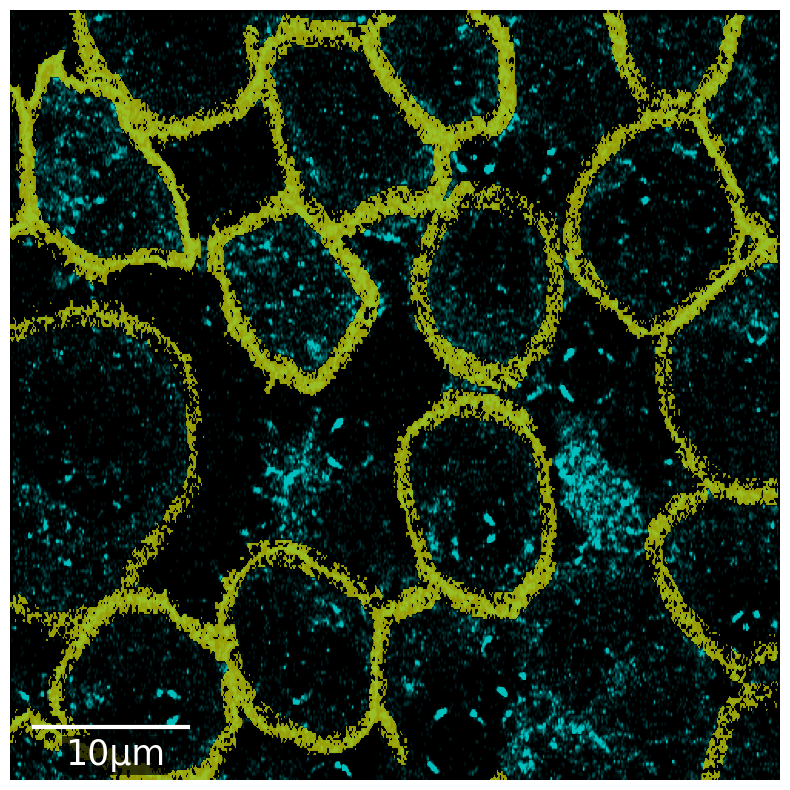

In [5]:
%matplotlib inline
for file in files:
    # folders
    input_img_folder = f"membrane/seg_dataframes"
    #input_seg_folder = f"membrane/prob_map"

    # load item
    item = datastruc.item(None, None, None, None, None)
    item.load_from_parquet(os.path.join(input_img_folder, file+'.parquet'))
    item._coord_2_pixel()

    # render histogram & convert to img
    histo, channel_map, label_map = item.render_histo(channels)
    print(label_map)
    img = np.transpose(histo, (0, 2, 1))

    # render segmentation
    item.histo_mask = item.render_seg()

    # only visualise one channel
    vis_img.visualise_seg(
        img,
        item.histo_mask.T,
        item.bin_sizes, 
        axes=[0],
        label_map=label_map,
        threshold=threshold,
        how=interpolation,
        alphas=alphas,
        blend_overlays=False,
        alpha_seg=alpha_seg,
        cmap_img=None,
        cmap_seg=cmap_seg,
        figsize=figsize,
        origin="upper",
        save=save,
        save_loc=save_loc,
        save_name=file,
        four_colour=four_colour,
        background_one_colour=background_one_colour,
        legend=legend,
        show=True,
        vmin_img=vmin_img,
        vmax_img=vmax_img,
        sum_chans=sum_chans
    )

### Clustering for membrane/non-membrane EGFR

Channel 1 is egfr
Non-membrane egfr
---------------------
Mean locs per cluster 22.084727468969238
Std locs per cluster 74.47919289468835
Median locs per cluster 8.0
Mean cluster area 47301.743956682345
Std cluster area 268359.9526128161
Median cluster area 9752.552579879377
Mean perimeter 644.7179324030432
Std perimeter 649.7864256703182
Median perimeter 455.76524471669916
Mean cluster length 264.25395993987047
Std cluster length 260.902170624833
Median cluster length 187.2149008112237
---------------------
Membrane egfr
---------------------
Mean locs per cluster 41.83988065638986
Std locs per cluster 154.36537460325636
Median locs per cluster 10.0
Mean cluster area 158864.70691114233
Std cluster area 1294343.1680983128
Median cluster area 15081.286315918076
Mean perimeter 965.0791657917905
Std perimeter 1461.175645751638
Median perimeter 541.2039641830216
Mean cluster length 394.2658834256493
Std cluster length 622.2508929601746
Median cluster length 219.99857638505344
-------------

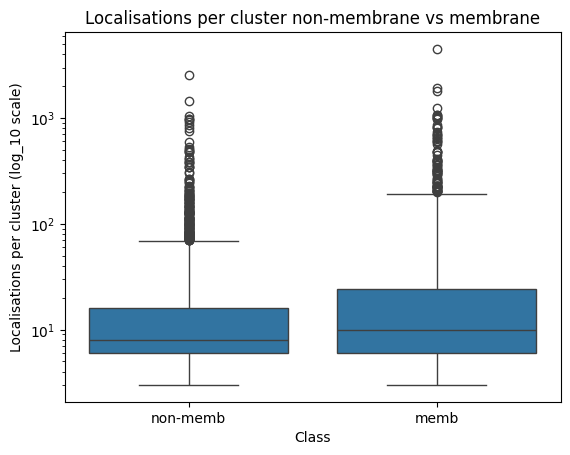

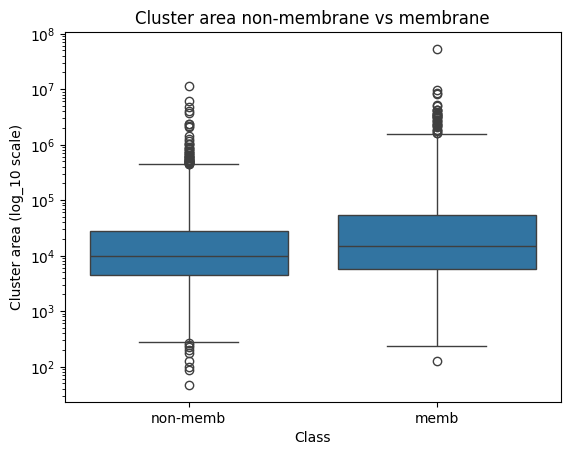

In [6]:
print(f"Channel 1 is {item.chan_2_label(1)}")

# Cluster for only non-membrane proteins
non_memb_df = item.df.filter(pl.col("gt_label") == 0)
#non_memb_chan_zero_arr = non_memb_df.filter(pl.col("channel") == 0)
non_memb_chan_one_arr = non_memb_df.filter(pl.col("channel") == 1)
#print("Non-membrane channel zero")
#print("---------------------")
#cluster(non_memb_chan_zero_arr, eps, min_samples)
#print("---------------------")
print(f"Non-membrane {item.chan_2_label(1)}")
print("---------------------")
results = cluster(non_memb_chan_one_arr, eps, min_samples)
locs_per_cluster_non_memb, cluster_area_non_memb = results[-2:]
print("---------------------")


# Cluster for only non-membrane proteins
memb_df = item.df.filter(pl.col("gt_label") == 1)
#memb_chan_zero_arr = memb_df.filter(pl.col("channel") == 0)
memb_chan_one_arr = memb_df.filter(pl.col("channel") == 1)
#print("Membrane channel zero")
#print("---------------------")
#cluster(memb_chan_zero_arr, eps, min_samples)
#print("---------------------")
print(f"Membrane {item.chan_2_label(1)}")
print("---------------------")
results = cluster(memb_chan_one_arr, eps, min_samples)
locs_per_cluster_memb, cluster_area_memb = results[-2:]
print("---------------------")

# Boxplots
data = {
    'locs_per_cluster': np.concatenate((locs_per_cluster_non_memb ,locs_per_cluster_memb)),
    'cluster_area': np.concatenate((cluster_area_non_memb, cluster_area_memb)),
    'class': ['non-memb'] * len(locs_per_cluster_non_memb) + ['memb'] * len(locs_per_cluster_memb)
}

df = pd.DataFrame(data)

# Create the boxplot
sns.boxplot(x='class', y='locs_per_cluster', data=df, log_scale=True)
plt.ylabel("Localisations per cluster (log_10 scale)")
plt.xlabel("Class")
plt.title('Localisations per cluster non-membrane vs membrane')
plt.show()
sns.boxplot(x='class', y='cluster_area', data=df, log_scale=True)
plt.ylabel("Cluster area (log_10 scale)")
plt.xlabel("Class")
plt.title('Cluster area non-membrane vs membrane')
plt.show()

## Cell segmentation

### Visualise

In [7]:
files = ["C15_EREG568_EGFR647_FOV3"]
channels = ["egfr", 'ereg']
threshold = 0
interpolation = 'linear'
alphas = [1,.5,.2,.1]
alpha_seg = 0.7
# cmap_seg = ["k", "y"]
cmap_img = ['w']
figsize = [10,10]
four_colour = True
background_one_colour = False
legend=False
column_vis="pred_label"
vmin_img=0
vmax_img=6
sum_chans=True
save=False
save_loc=None

['egfr', 'ereg']
file C15_EREG568_EGFR647_FOV3


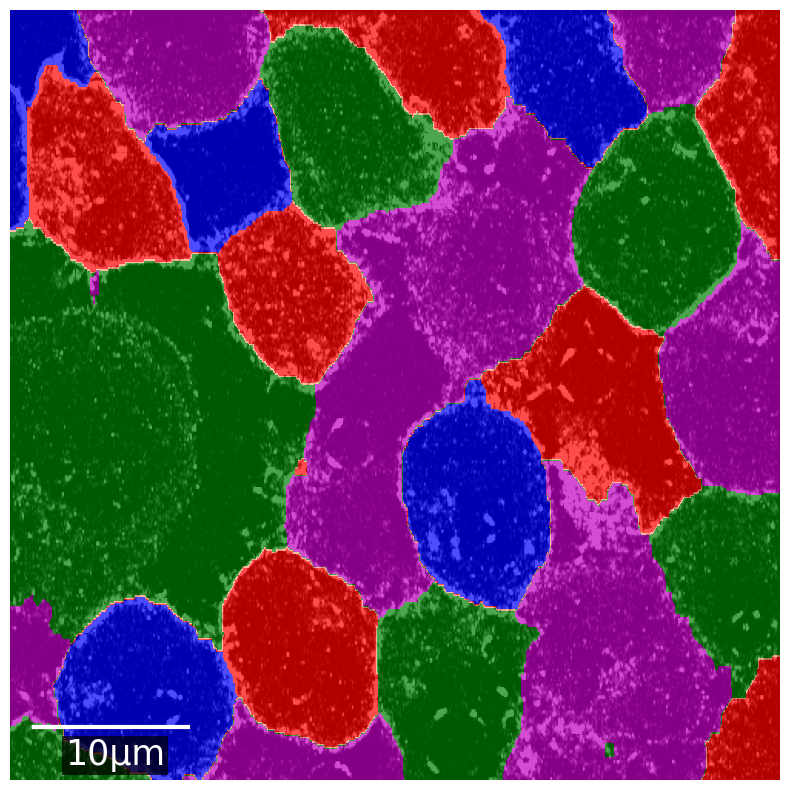

In [8]:
for file in files:
    # folders
    input_img_folder = f"cell/seg_dataframes"
    input_seg_folder = f"cell/seg_img"

    # load item
    item = datastruc.item(None, None, None, None, None)
    item.load_from_parquet(os.path.join(input_img_folder, file+'.parquet'))
    item._coord_2_pixel()

    # render histogram & convert to img
    histo, channel_map, label_map = item.render_histo(channels)
    print(label_map)
    img = np.transpose(histo, (0, 2, 1))

    # load segmentation
    segmentation = np.load(os.path.join(input_seg_folder, file+'.npy'))

    print('file', file)

    # only visualise one channel
    vis_img.visualise_seg(
        img,
        segmentation,    
        item.bin_sizes, 
        axes=[0],
        label_map=label_map,
        threshold=threshold, 
        cmap_img=cmap_img,
        how=interpolation, 
        # alphas=alphas, 
        blend_overlays=True,
        alpha_seg=alpha_seg,
        # cmap_img=None, 
        # cmap_seg=cmap_seg, 
        figsize=figsize, 
        origin="upper",
        save=save,
        save_loc=save_loc,
        save_name=file,
        four_colour=four_colour, 
        #background_one_colour=background_one_colour, 
        legend=legend,
        show=True,
        vmin_img=vmin_img,
        vmax_img=vmax_img,
        sum_chans=sum_chans
    )

### Cluster per cell for only channel zero

In [12]:
# Calculate cluster features per cell
channel_zero = item.df.filter(pl.col("channel") == 0)
df_split = channel_zero.partition_by("pred_label")

property_dict = {}
for df in df_split:
    results = cluster(df, eps, min_samples, print_results=False)
    property_dict[df["pred_label"].unique().item()] = results[:-2]

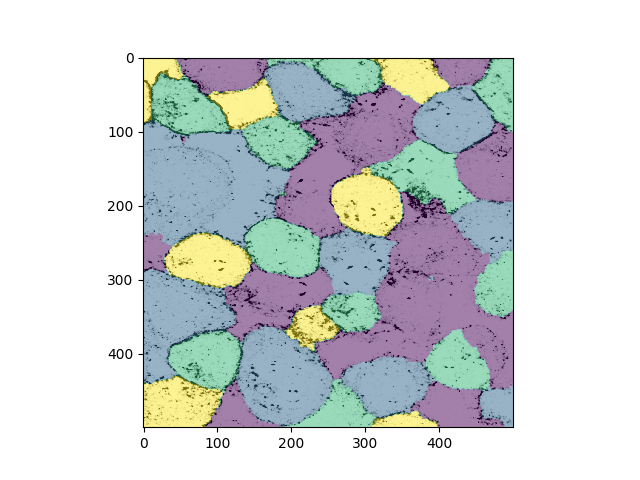

In [13]:
# Visualise cluster features per cell
%matplotlib widget
import mplcursors
import networkx as nx
from skimage.graph import RAG

img_plot = np.sum(img, axis=0)
fig, axes = plt.subplots(ncols=1)
axes.imshow(img_plot, 
           cmap='Grays',
           vmin=0,
           vmax=10,
           origin="upper")

def label_2_4_colours(labels: np.ndarray):
    """This takes in an array of labels
    e.g. [5,0,2,2,17,1,...]
    and returns a list where each label is now
    in range 0-3 such that no 2 integers next to
    each other are the same.
    This can be used for to plot so no 2 colours
    next to each other are the same

    Args:
        labels (np.ndarray): Array of ints
        each representing a unique label

    Returns:
        Array of ints each representing a
        unique label (between 0 and 3) no
        2 of same label should be next to each other"""

    graph = RAG(labels)
    d = nx.coloring.greedy_color(graph)
    # dict empty and only one label
    if not d and np.min(labels) == np.max(labels):
        d = {np.min(labels): 0}
    return np.vectorize(d.get)(labels)


segmentation_MOD = label_2_4_colours(segmentation)

axes.imshow(segmentation_MOD,
           alpha=.5,
           origin="upper")

cursor = mplcursors.cursor(hover=True)
cursor.connect(
    "add", lambda sel: sel.annotation.set_text(f"mean locs_per_cluster: {property_dict[segmentation[sel.index]][0]}\n\
std locs_per_cluster: {property_dict[segmentation[sel.index]][1]}\n\
median locs_per_cluster: {property_dict[segmentation[sel.index]][2]}\n\
mean cluster_area: {property_dict[segmentation[sel.index]][3]}\n\
std cluster_area: {property_dict[segmentation[sel.index]][4]}\n\
median cluster_area: {property_dict[segmentation[sel.index]][5]}"))
plt.show()
